COMP4423 – Computer Vision

Group Project: Fashion Image Generation

Group 1

JIANG Yiyang (21095707d)  
YE Haowen (21098829d)  
ZHANG Wengyu (21098431d)  

April 2023

---

### This is the **c'P'CGAN model training and validation Trial program** for the Project

### Conditional 'Partial' Convolutional GAN (c'P'CGAN) is our self-invented model, only as a trial, not in actual usage.

<font color='red' size='5'> Please carefully read User_Manual.pdf file first before running </font>

### The model's performance is not good, so we did not consider it as a candidate model.

In [1]:
from torchvision import transforms
import torch
import numpy as np
import pandas as pd
from torch import nn, optim
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from PIL import Image
from collections import Counter
from sklearn.manifold import TSNE
from time import time
from datetime import datetime
import copy
import seaborn as sns

torch.__version__

torch.manual_seed(42)

trainPath = '../fashion-mnist/train.csv' # Path of data
testPath = '../fashion-mnist/test.csv' # Path of data

labelMap = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

batch_size = 64

learning_rate = 0.0001

In [2]:
class Sample:
    def __init__(self, idx=0, img=None, feat = None, label=None):
        self.idx = idx
        self.img = img
        self.feat = feat
        self.label = label
        
def loadImage():
    samples = []
    dataCsv = pd.read_csv(trainPath)
    dataCsvImg = dataCsv.drop(columns = 'label')
    dataCsvImg = dataCsvImg.values.astype('uint8')
    
    images = dataCsvImg.reshape(-1, 28, 28)
    labels = dataCsv['label'].values
    
    for i in range (len(images)):
        sample = Sample(idx=i, img=images[i], feat = dataCsvImg[i], label=labels[i])
        samples.append(sample)
    return samples, images, labels

allSamples, allImages, allLabels = loadImage()

In [3]:
class FashionDataset(Dataset):
    def __init__(self, inImages, inLabels, transform=None):
        self.transform = transform
        self.images = inImages
        self.labels = inLabels
       
    def __len__(self):
       return len(self.images)
    
    def __getitem__(self, idx):
        img = self.transform(Image.fromarray(self.images[idx]))
        label = self.labels[idx]
        return img, label

transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
])
train = FashionDataset(allImages, allLabels, transform = transform)
train_loader = torch.utils.data.DataLoader(train, batch_size = batch_size, shuffle = True)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


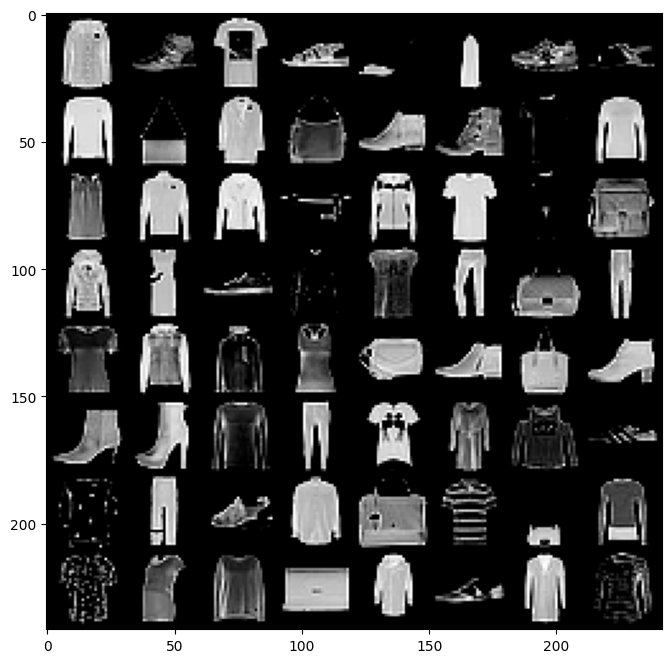

In [4]:
## functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

## get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

## show images
imshow(make_grid(images[0:64],nrow=8))

In [2]:
# construct 

# layerSize = [32, 64, 128]
# layerSize = [64, 128, 256]
# layerSize = [128, 256, 512]
layerSize = [256, 512, 1024] # 16*16

randomChannelSize = 32
randomGenerateLength = 7 # 7*7 -> 14*14 -> 28*28

class generator(nn.Module):
    def __init__(self):
        super().__init__()
        #100+10->32->64->128->784
        
        self.label_layer = nn.Embedding(10, 10)
        
        self.dense0 = nn.Linear(100+10, layerSize[0])
        self.dense1 = nn.Linear(layerSize[0], layerSize[1])
        self.dense2 = nn.Linear(layerSize[1], layerSize[2])
        self.dense3 = nn.Linear(layerSize[2], 784)
        self.dropout = nn.Dropout(0.3)


    def forward(self, X, labels):
        # append labels to X
        X = X.view(X.shape[0], 100)
        L = self.label_layer(labels)
        X = torch.cat([X, L], dim = 1)

        X = self.dropout(F.leaky_relu(self.dense0(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense1(X), 0.2))
        X = self.dropout(F.leaky_relu(self.dense2(X), 0.2))
        X = torch.tanh(self.dense3(X)) 
        X = X.view(X.shape[0], 1, 28, 28) # convert to image
        return X

class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_layer = nn.Sequential(
            nn.Embedding(10, 10),
            nn.Linear(10, 28*28)
        )
        
        self.model = nn.Sequential(
            nn.Conv2d(1+1, randomChannelSize, kernel_size=3, stride=2, padding=1), # 28*28 -> 14*14
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            
            nn.Conv2d(randomChannelSize, randomChannelSize, kernel_size=3, stride=2, padding=1), # 14*14 -> 7*7
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Flatten(),
            
            nn.Linear(randomChannelSize*7*7, 1),
        )
    
    def forward(self, X, labels):
        L = self.label_layer(labels).view(X.shape[0], 1, 28, 28) 
        X = torch.cat([X, L], dim = 1)
        X = self.model(X)
        return X

In [5]:
G = generator()
D = discriminator()

G_optimizer = optim.Adam(G.parameters(), lr = learning_rate)
D_optimizer = optim.Adam(D.parameters(), lr = learning_rate)

criterion = nn.BCEWithLogitsLoss() # combine sigmoid with and BCELoss

# Set proper device according to your machine!
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
# device = torch.device('mps') # use 'mps' if your Mac has Apple Silicon MPS GPU acceleration
print(device)

G.to(device)
D.to(device)

mps


discriminator(
  (label_layer): Sequential(
    (0): Embedding(10, 10)
    (1): Linear(in_features=10, out_features=784, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(2, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=1568, out_features=1, bias=True)
  )
)

EPOCH 010 finalized: discriminator loss 0.001482 - gererator loss 0.000766, time 313.275759s


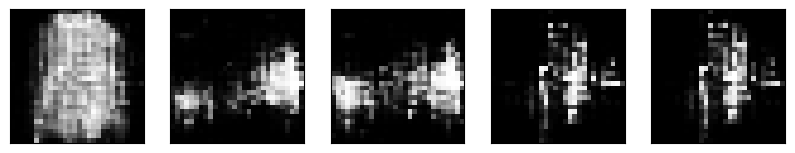

EPOCH 020 finalized: discriminator loss 0.001482 - gererator loss 0.000711, time 627.967232s


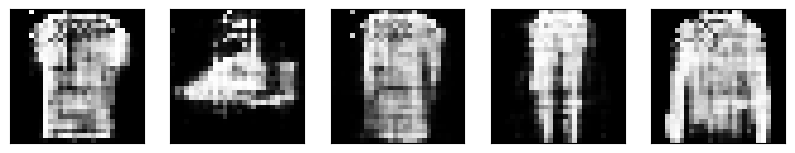

EPOCH 030 finalized: discriminator loss 0.001454 - gererator loss 0.000818, time 941.862633s


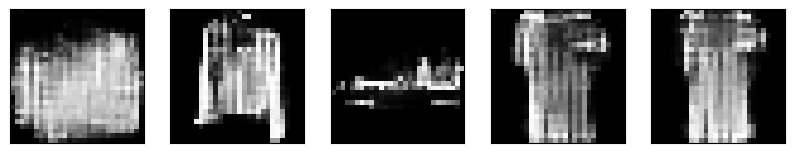

EPOCH 040 finalized: discriminator loss 0.001508 - gererator loss 0.000767, time 1238.528265s


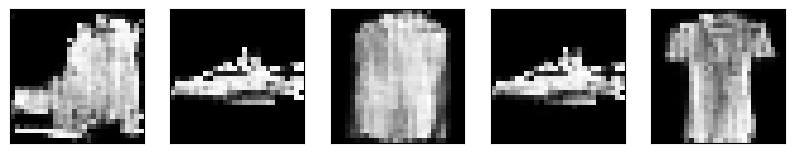

EPOCH 050 finalized: discriminator loss 0.001404 - gererator loss 0.000771, time 1534.688779s


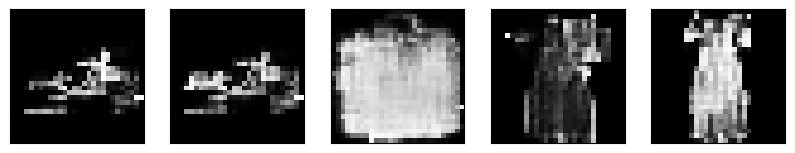

EPOCH 060 finalized: discriminator loss 0.001362 - gererator loss 0.000794, time 1823.141923s


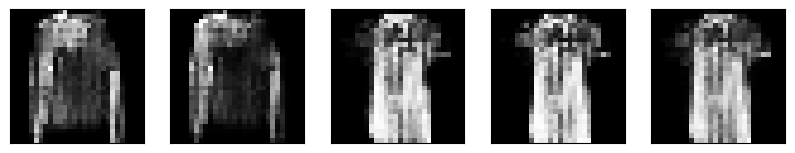

EPOCH 070 finalized: discriminator loss 0.001513 - gererator loss 0.000787, time 2116.540637s


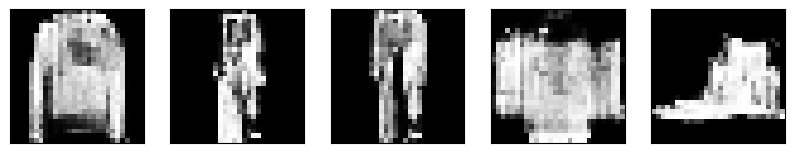

EPOCH 080 finalized: discriminator loss 0.001455 - gererator loss 0.000817, time 2415.669491s


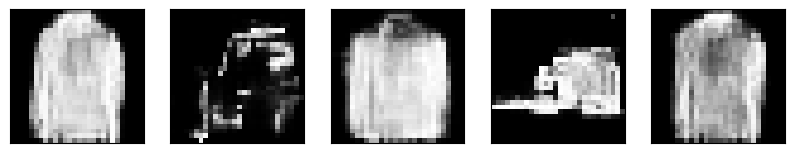

EPOCH 090 finalized: discriminator loss 0.001479 - gererator loss 0.000828, time 2722.013162s


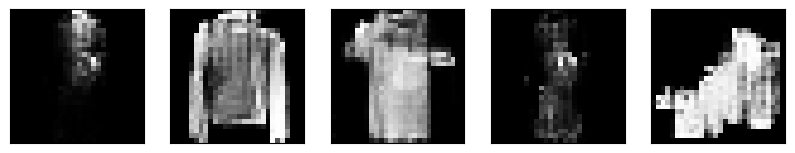

EPOCH 100 finalized: discriminator loss 0.001365 - gererator loss 0.000753, time 3022.442178s


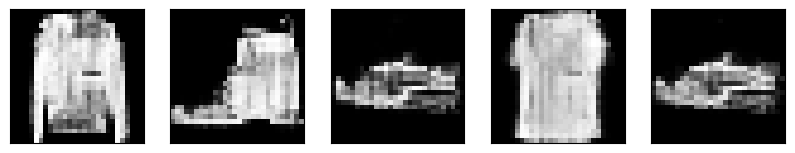

Model saved to cPCGAN_G_256_100.pth


In [16]:
EPOCH = 100
gLoss = dict()
dLoss = dict()
startTime = datetime.now()
for epoch in range(EPOCH):
    D_running_loss = 0
    G_running_loss = 0
    
    for i, (images_real, labels_real) in enumerate(train_loader):
        batch_size = images_real.size(0)
        # images_real = images_real * 2 - 1
        images_real = images_real.to(device)
        labels_real = labels_real.to(device)

        # Train The Generator
        G_optimizer.zero_grad()
        
        random = torch.randn(batch_size, 100).to(device)
        
        random_labels = torch.randint(low=0, high=10, size=(batch_size,), device=device)    
        images_false = G.forward(random, random_labels)
        output_false = D.forward(images_false, random_labels)
        
        labels_false = torch.ones(batch_size).to(device)
        G_loss = criterion(output_false.view(*labels_false.shape), labels_false)
        G_loss.backward()
        G_optimizer.step()

        # Train The Discriminator
        D_optimizer.zero_grad()
        
        # real images
        
        outputs_real = D.forward(images_real, labels_real)
        labels_real_false = (torch.ones(batch_size)).to(device)
        D_loss_real = criterion(outputs_real.view(*labels_real_false.shape), labels_real_false)

        # false images
        random = torch.randn(batch_size, 100).to(device)
        
        random_labels = torch.randint(low=0, high=10, size=(batch_size,), device=device)
        
        images_false = G.forward(random, random_labels)
        outputs_false = D.forward(images_false, random_labels)
        
        labels_false = torch.zeros(batch_size).to(device)
        D_loss_false = criterion(outputs_false.view(*labels_false.shape), labels_false)

        D_loss = D_loss_real + D_loss_false
        D_loss.backward()
        D_optimizer.step()

        D_running_loss += D_loss.item()
        G_running_loss += G_loss.item()
        
        D_running_loss /= len(train_loader)
        G_running_loss /= len(train_loader)
        
        gLoss[epoch] = G_running_loss
        dLoss[epoch] = D_running_loss
  
    if (epoch + 1) % 10 == 0:
        endTime = datetime.now()
        duration = (endTime - startTime).total_seconds()
        # print the loss after each epoch
        print('EPOCH {:03d} finalized: discriminator loss {:03.6f} - gererator loss {:03.6f}, time {:03.6f}s'.format(epoch + 1, D_running_loss, G_running_loss, duration))

        fig, ax = plt.subplots(1, 5, figsize=(10,5))
        for i in range(5):
            ax[i].imshow(images_false.cpu().detach().numpy()[i].reshape(28, 28), cmap='gray')
            ax[i].xaxis.set_visible(False)
            ax[i].yaxis.set_visible(False)
        plt.show()
savePath = 'cPCGAN_G_256_100.pth'
torch.save(G, savePath)
print('Model saved to {}'.format(savePath))

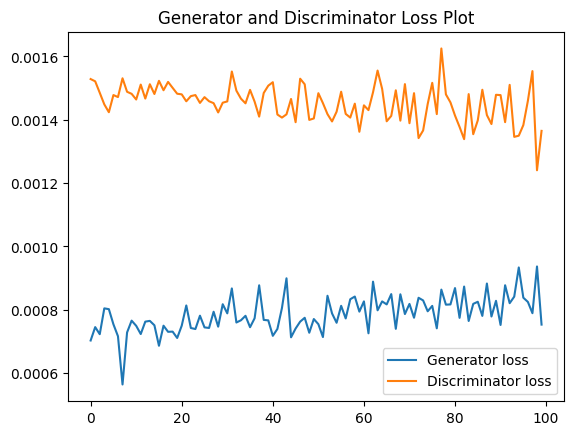

In [17]:
plt.title("Generator and Discriminator Loss Plot")
plt.plot(gLoss.keys(),gLoss.values(), label="Generator loss")
plt.plot(dLoss.keys(),dLoss.values(), label="Discriminator loss")
plt.legend()
plt.show()

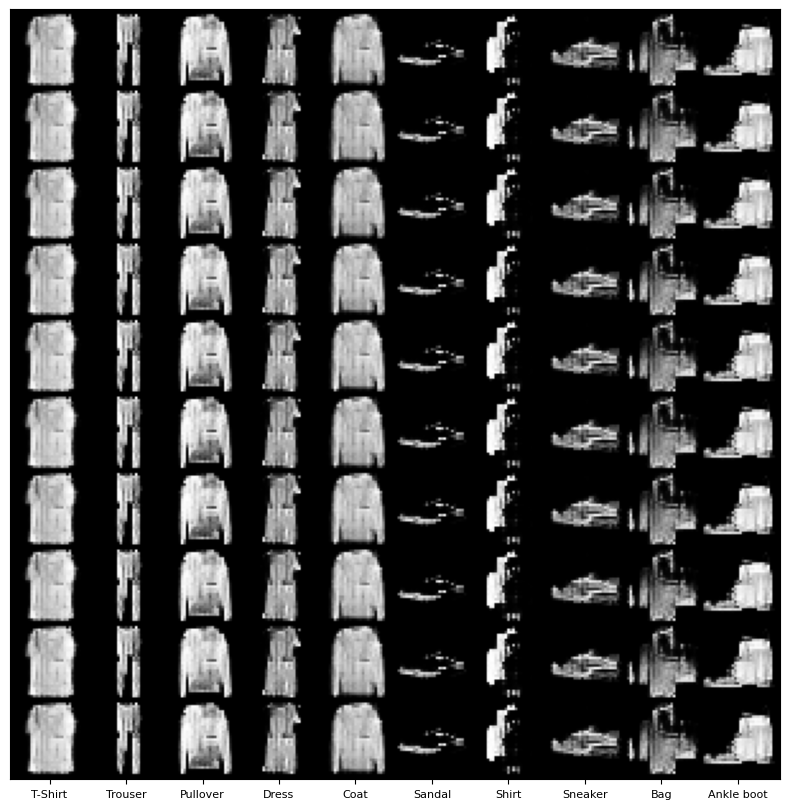

In [6]:
device = torch.device('cpu')

G = torch.load('./cPCGAN_G_256_100.pth', map_location=device)

random = torch.randn(100, 100).to(device)
random_labels = np.array([i for _ in range(10) for i in range(10)])
random_labels = torch.from_numpy(random_labels).int().to(device)

G.eval()
output  = G.forward(random, random_labels).unsqueeze(1).data.cpu()
output = output.view(100, 1, 28, 28)

# Show images
grid = make_grid(output, nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid)
a = plt.yticks([])
b = plt.xticks(np.arange(15, 300, 30), labelMap, fontsize=8)


The model's performance is not good, so we did not consider it as a candidate model.